# Motivation Plotting for the paper

Content:
1. file loading
2. select the target files
3. plot one single file
4. plot all files

Load the file according to the parameters

In [21]:
from statistics import mean, stdev
def log_file_path(memtable_size,cpu_count,storage_device="StorageMaterial.NVMeSSD",l0_optimized="",workload_size=100,prefix="Resources/"):
    target_path = prefix + str(workload_size) +"GB/"
    if l0_optimized:
        target_path = target_path + l0_optimized + "/"
    
    target_path += "%s/%s/%s" % (storage_device,
               str(cpu_count)+"CPU",
               str(memtable_size)+"MB")
    return target_path
# you can test it like this


class CompactionDetail:
    job_id=0
    compaction_start_micro=0
    compaction_latency_micro=0
    compaction_cpu_micro=0
    compaction_reason=""
    
print(log_file_path(32,12,"StorageMaterial.NVMeSSD"))

Resources/100GB/StorageMaterial.NVMeSSD/12CPU/32MB


List all files according to the parameter lists

In [22]:
# materials = ['NVMeSSD','SATASSD','PM']
materials = ['NVMeSSD']
cpu_count_array = [12]
memtable_size_array = [32]

import os
import glob
def find_log_file(log_dir):
    log_file = [filename for filename in glob.glob(
                log_dir+"/**") if "LOG" in filename][0]
    
    return log_file

log_files = []

for material in materials: 
    for cpu_count in cpu_count_array: 
        for memtable_size in memtable_size_array:
            log_dir = log_file_path(memtable_size,cpu_count,
                                  "StorageMaterial."+material)
            log_files.append(find_log_file(log_dir))

In [23]:
# importing and macro definition

import re
import json
job_id_dict = {}
event_row_dict = {}
EVENTS_NEED_COLLECTED = ['compaction_started','compaction_finished','flush_finished']


choose the first file from the list

ps: the reason for use a dictation instead of a list to store the job id is for further modification, maybe we need to 
monitor the flush or other kinds of job.

In [24]:
def handle_single_file(file):
    job_dict = {}
    event_dict = {}
    
    for event in EVENTS_NEED_COLLECTED:
        event_dict[event] = {}
        job_dict[event] = []
        
    file_content = open(file,"r").readlines()
    
    for line in file_content:
        line = re.search('(\{.+\})', line)
        if line:
            try:
                log_row = json.loads(line[0])
                job_id = int(log_row['job'])
                current_event = log_row['event']
                if current_event in EVENTS_NEED_COLLECTED:
                    if job_id not in job_dict[current_event]:
                        event_dict[current_event][job_id] = [log_row]
                        job_dict[current_event].append(job_id)
                    else:
                        event_dict[current_event][job_id].append(log_row)
                        print(log_row)
            except json.decoder.JSONDecodeError:
                pass
    return job_dict,event_dict

# job_id_dict,event_row_dict = handle_single_file(log_files[0]) 
# 
# print(job_id_dict.keys())
# print(event_row_dict.keys())

Compare the cpu time spend on L0 compaction and high level compactions

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.ticker as ticker

plt.rcParams.update({'font.size': 24})

@ticker.FuncFormatter
def y_major_formatter(y,ps):
    return "%.1e" % y
@ticker.FuncFormatter
def yr_major_formatter(y,ps):
    return ""

# cpu_time_plot_single_file("",job_id_dict,event_row_dict)

def plot_single_file(result_prefix,job_dict,event_dict,event_name,column_name,image_comments):
    compaction_reason_dict = {}
    compaction_latencies = []
    compaction_cpu_time = []
    # group the compaction according to the reason
    for compaction_job in job_dict['compaction_started']:    
        compaction_start_row = event_dict['compaction_started'][compaction_job][0]
        compaction_finish_row = event_dict['compaction_finished'][compaction_job][0]
        current_reason = compaction_start_row['compaction_reason']
        
        if current_reason not in compaction_reason_dict:
            compaction_reason_dict[current_reason] = []
        else:
            compaction_reason_dict[current_reason].append(compaction_job)
        compaction_latencies.append(compaction_finish_row['compaction_time_micros'])
        compaction_cpu_time.append(compaction_finish_row['compaction_time_cpu_micros'])
    reason_count = len(compaction_reason_dict.keys())
    
    fig = plt.figure(figsize=(16, 9))
    grid = plt.GridSpec(9,13,hspace=6,wspace=1.5)
    l0_compaction = fig.add_subplot(grid[0:4,1:12])
    high_level_compaction = fig.add_subplot(grid[4:8,1:12],sharey=l0_compaction)
    # set the tile
    l0_compaction.set_title("Compaction latency of L0-L1 compaction")
    high_level_compaction.set_title("Compaction latency of other compactions")
    
    color_bar = fig.add_subplot(grid[:-1,-1:])
    
    # determine the color bar first
    cmap = mpl.cm.winter_r
    norm = mpl.colors.Normalize(vmin=min(compaction_latencies), vmax=max(compaction_latencies))
    # print(min(compaction_latencies),max(compaction_latenc))
    cb1 = mpl.colorbar.ColorbarBase(color_bar, cmap=cmap,
                                    norm=norm,
                                    orientation='vertical')
    cb1.ax.yaxis.set_major_formatter(y_major_formatter)
    cb1.set_label('Processing Time(ms)')
    
    # add data to plot
    l0_compaction_ids = compaction_reason_dict['LevelL0FilesNum']
    high_level_compaction_ids = compaction_reason_dict['LevelMaxLevelSize']
    
    l0_compaction_cpu_times = []
    high_level_compaction_cpu_times = []
    
    for id in l0_compaction_ids:
        # event_row_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']
        l0_compaction_cpu_times.append(float(event_dict[event_name][id][0][column_name]))
    for id in high_level_compaction_ids:
        high_level_compaction_cpu_times.append(float(event_dict[event_name][id][0][column_name]))
    # l0_compaction.yaxis.get_major_formatter().set_powerlimits((0,1))
    # high_level_compaction.yaxis.get_major_formatter().set_powerlimits((0,1))
    
    l0_compaction.yaxis.set_major_formatter(yr_major_formatter)
    # l0_compaction.set_xticks([])
    
    l0_compaction.scatter(l0_compaction_ids,l0_compaction_cpu_times,
                          c=l0_compaction_cpu_times,
                          cmap=cmap)
    high_level_compaction.scatter(high_level_compaction_ids,high_level_compaction_cpu_times,c=high_level_compaction_cpu_times
                                  ,cmap=cmap,norm=norm)    
    # high_level_compaction.set_xlabel("compaction job id")
    # print(result_prefix.split("+")[-2],'sum '+column_name+' in L0',np.sum(l0_compaction_cpu_times))
    # print(result_prefix.split("+")[-2],'sum '+column_name+' in higher levels', np.sum(high_level_compaction_cpu_times))
    # print(result_prefix.split("+")[-2],'sum '+column_name, np.sum(high_level_compaction_cpu_times) + np.sum(l0_compaction_cpu_times))
    # # print(result_prefix.split("+")[-2],'L0/High Level',len(l0_compaction_cpu_times),'/',len(high_level_compaction_cpu_times))
    # fig.suptitle(result_prefix)
    
    # print("l0 compaction",mean(l0_compaction_cpu_times),stdev(l0_compaction_cpu_times))
    # print("highlevel compation", mean(high_level_compaction_cpu_times),stdev(high_level_compaction_cpu_times))
    high_level_compaction_cpu_times.extend(l0_compaction_cpu_times)
    print("highlevel compation,%.2E,%.2E"%(mean(high_level_compaction_cpu_times),stdev(high_level_compaction_cpu_times)))

    fig.savefig('figure/'+result_prefix+image_comments+".pdf",bbox_inches='tight')

def total_time_plot_single_file(result_prefix,job_dict,event_dict):
    plot_single_file(result_prefix,job_dict,event_dict,'compaction_finished','compaction_time_micros','total')

def cpu_time_plot_single_file(result_prefix,job_dict,event_dict):
    plot_single_file(result_prefix,job_dict,event_dict,'compaction_finished','compaction_time_cpu_micros','cpu')

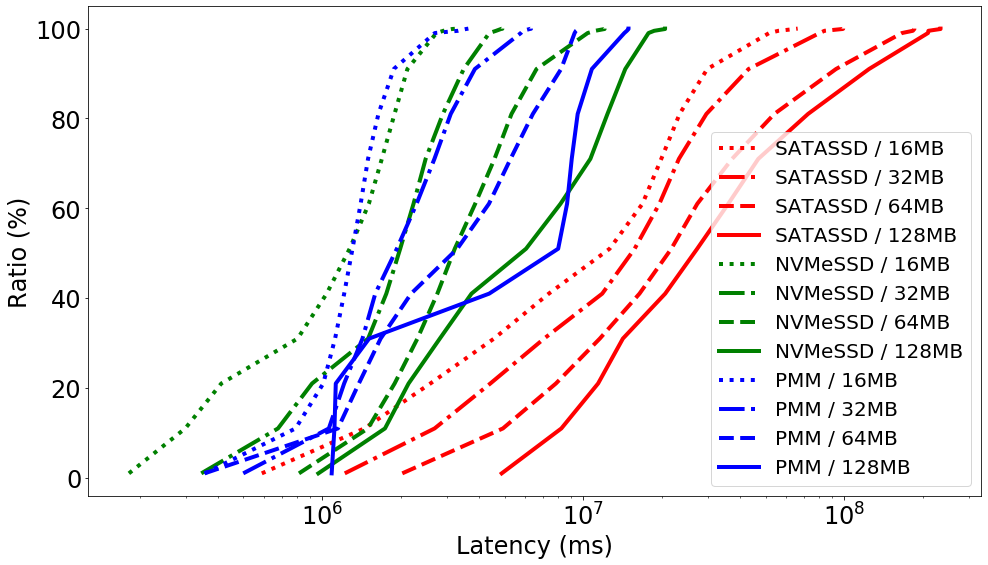

In [28]:
dash_dict={"SATASSD":"-","NVMeSSD":"--","PM":":"}
material_color_dict={"SATASSD":"r","NVMeSSD":"g","PM":"b"}
block_marker_dict = {"16MB":".","32MB":"s","64MB":"+","128MB":"x"}
block_dash_dict = {"16MB":":","32MB":"-.","64MB":"--","128MB":"-"}

color_dict = {"2CPU":"r","4CPU":"g","8CPU":"b"}
block_dict = {"16MB":"r","32MB":"g","64MB":"b","128MB":"y"}
def compaction_hist_block_size(result_prefix,job_dict,event_dict,shared_fig):
    compaction_reason_dict = {}
    compaction_latencies = []
    compaction_cpu_time = []
    # group the compaction according to the reason
    for compaction_job in job_dict['compaction_started']:    
        compaction_start_row = event_dict['compaction_started'][compaction_job][0]
        compaction_finish_row = event_dict['compaction_finished'][compaction_job][0]
        current_reason = compaction_start_row['compaction_reason']
        
        if current_reason not in compaction_reason_dict:
            compaction_reason_dict[current_reason] = []
        else:
            compaction_reason_dict[current_reason].append(compaction_job)
            compaction_latencies.append(compaction_finish_row['compaction_time_micros'])
            compaction_cpu_time.append(compaction_finish_row['compaction_time_cpu_micros'])
    reason_count = len(compaction_reason_dict.keys())
    l0_compaction_ids = compaction_reason_dict['LevelL0FilesNum']
    high_level_compaction_ids = compaction_reason_dict['LevelMaxLevelSize']
    
    l0_compaction_cpu_times = []
    high_level_compaction_cpu_times = []
    
    for id in l0_compaction_ids:
        # event_row_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']
        l0_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]["compaction_time_micros"]))
    for id in high_level_compaction_ids:
        high_level_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]["compaction_time_micros"]))

    compaction_latencies.sort()
    x = list(range(1,100,10))
    x.extend([99,99.50,99.90,99.95,99.99])
    x.sort()
    y = [ compaction_latencies[int((float(order)/100) * len(compaction_latencies))] for order in x]
    material_str = result_prefix.split("+")[-4].split(".")[-1]

    block_str = result_prefix.split("+")[-2]
    label_str = material_str +" / "+block_str
    if material_str == "PM":
        label_str = "PMM" +" / "+block_str
    shared_fig.plot(y,x,label=label_str,linestyle =block_dash_dict[block_str],linewidth=4,c=material_color_dict[material_str])
    
    
def compaction_hist_cpu_count(result_prefix,job_dict,event_dict,shared_fig):
    compaction_reason_dict = {}
    compaction_latencies = []
    compaction_cpu_time = []
    # group the compaction according to the reason
    for compaction_job in job_dict['compaction_started']:    
        compaction_start_row = event_dict['compaction_started'][compaction_job][0]
        compaction_finish_row = event_dict['compaction_finished'][compaction_job][0]
        current_reason = compaction_start_row['compaction_reason']
        
        if current_reason not in compaction_reason_dict:
            compaction_reason_dict[current_reason] = []
        else:
            compaction_reason_dict[current_reason].append(compaction_job)
            compaction_latencies.append(compaction_finish_row['compaction_time_micros'])
            compaction_cpu_time.append(compaction_finish_row['compaction_time_cpu_micros'])
    reason_count = len(compaction_reason_dict.keys())
    l0_compaction_ids = compaction_reason_dict['LevelL0FilesNum']
    high_level_compaction_ids = compaction_reason_dict['LevelMaxLevelSize']
    
    l0_compaction_cpu_times = []
    high_level_compaction_cpu_times = []
    
    for id in l0_compaction_ids:
        # event_row_dict['compaction_finished'][id][0]['compaction_time_cpu_micros']
        l0_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]["compaction_time_micros"])
                                       - float(event_dict['compaction_finished'][id][0]["compaction_time_cpu_micros"]))
    for id in high_level_compaction_ids:
        high_level_compaction_cpu_times.append(float(event_dict['compaction_finished'][id][0]["compaction_time_micros"])
                                       - float(event_dict['compaction_finished'][id][0]["compaction_time_cpu_micros"]))
            #append(float(event_dict['compaction_finished'][id][0]["compaction_time_micros"]))

    compaction_latencies.sort()
    # print(compaction_latencies)
    x = list(range(0,100,10))
    x.extend([99,99.50,99.90,99.95,99.99])
    x.sort()
    y = [ compaction_latencies[int((float(order)/100) * len(compaction_latencies))] for order in x]
    material_str = result_prefix.split("+")[-4].split(".")[-1]
    cpu_str = result_prefix.split("+")[-3]
    

    label_str = material_str +" / "+cpu_str
    if material_str == "PM":
        label_str = "PMM" +" / "+cpu_str
    shared_fig.plot(y,x,label=label_str,linestyle=dash_dict[material_str],linewidth=4,c=color_dict[cpu_str])
    

# plt.rcParams.update({'font.size': 24})
# materials = ['SATASSD','NVMeSSD','PM']
# 
# cpu_count_array = [2,4,8]
# memtable_size_array = [64]
# l0configs=['tuned']
# 
# log_files = []
# 
# for material in materials: 
#     for cpu_count in cpu_count_array: 
#         for memtable_size in memtable_size_array:
#             for l0config in l0configs:
#                 log_dir = log_file_path(memtable_size,cpu_count,
#                                       "StorageMaterial."+material,l0_optimized=l0config,workload_size="45")
#                 log_files.append(find_log_file(log_dir))
# 
# fig = plt.figure(figsize=(16, 10)) 
# for log_file in log_files:
#     current_job_dict, current_event_dict = handle_single_file(log_file)
#     figure_prefix = log_file.replace("/","+")
#     rows = current_event_dict['flush_finished']
#     flush_times = []
#     flush_id = []
#     for row in rows:
#         flush_times.append(rows[row][0]['time_micros'])
#         flush_id.append(row)
# 
#     compaction_hist_cpu_count(str(figure_prefix),current_job_dict,current_event_dict,plt)
# 
# plt.legend(ncol=1,loc='lower right',fontsize=20)
# plt.ylabel("Ratio (%)")
# plt.xlabel("Latency (ms)")
# plt.xscale('symlog')
# fig.savefig('figure/iotime_cpu_influence_64.pdf',bbox_inches='tight')


materials = ['SATASSD','NVMeSSD','PM']
cpu_count_array = [8]
memtable_size_array = [16,32,64,128]
l0configs=['default']


log_files = []

for material in materials: 
    for cpu_count in cpu_count_array: 
        for memtable_size in memtable_size_array:
            for l0config in l0configs:
                log_dir = log_file_path(memtable_size,cpu_count,
                                      "StorageMaterial."+material,l0_optimized=l0config,workload_size="45")
                log_files.append(find_log_file(log_dir))

fig = plt.figure(figsize=(16, 9)) 
for log_file in log_files:
    current_job_dict, current_event_dict = handle_single_file(log_file)
    figure_prefix = log_file.replace("/","+")
    rows = current_event_dict['flush_finished']
    flush_times = []
    flush_id = []
    for row in rows:
        flush_times.append(rows[row][0]['time_micros'])
        flush_id.append(row)

    compaction_hist_block_size(str(figure_prefix),current_job_dict,current_event_dict,plt)

plt.legend(ncol=1,loc='lower right',fontsize=20)
plt.ylabel("Ratio (%)")
plt.xlabel("Latency (ms)")
plt.xscale('log')
fig.savefig('figure/all_unit_size_cpu8.pdf',bbox_inches='tight')